# Calculate domain size for baroclinic instability in the BBL
In this notebook I calculate a few of the predicted length scales for baroclinic instability during Ekman arrest of the bottom boundary layer. This is to help pick the right parameter set for LES simulations.

Author: Jacob Wenegrat 

Date: 1/30/2020

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

First note a few definitions.

The horizontal length scale of the fastest growing mode will be,
\begin{equation}
L = \frac{2\pi V}{f}\sqrt{\frac{1 + Ri}{5/2}}
\end{equation}
A reasonable simplification is to set $Ri=1$ as the point of marginal stability (for the regimes of interest where the slope Burger number $S = N\theta/f \ll 1$.

Next, note that the arrested Ekman layer height (which can be considered as a maximum height the boundary layer would achieve) is given by,

\begin{equation}
H_a = \frac{V_\infty f (1+S_\infty^2)}{N^2_\infty \theta}
\end{equation}

For the purposes of the LES simulations we therefore want to minimize $L$ and $H_a$, while keeping $S_\infty$ small (to allow fast growing baroclinic modes). We ideally would also use physically realistic values of the external problem parameters.

First note that we are very highly constrained in how we can affect the horizontal length scale of the instabilities, with the only adjustable parameters being V and f. 

An important question is how we scale V. If the boundary layer is in Ekman arrest, than $V=V_\infty$. So we can ask what is feasible for an interior velocity given our domain size constraints.

Text(0, 0.5, 'V $ms^{-1}$')

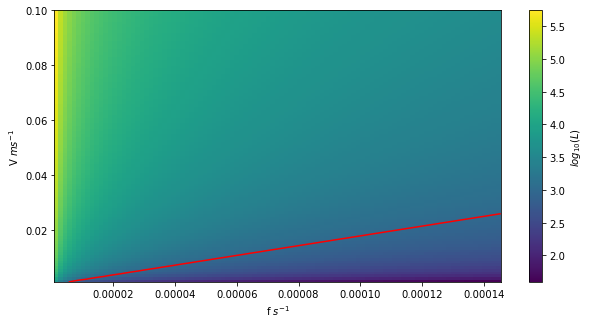

In [36]:
# Look at horizontal length scale as function of V and f
V = np.linspace(0.001, 0.1, 100)
f = np.linspace(1e-6, 2*2*np.pi/86400, 100)

L = 2*np.pi*V[:,np.newaxis]/f[np.newaxis,:]*np.sqrt(4/5)

plt.figure(figsize=(10,5))
plt.pcolor(f, V, np.log10(L))
cb = plt.colorbar()
cb.set_label('$log_{10}(L)$')
plt.contour(f, V, np.log10(L), [3], colors='r')
plt.xlabel('f $s^{-1}$')
plt.ylabel('V $ms^{-1}$')

So, if we want to do the fully arrested Ekman layer problem we are highly constrained in the magnitude of the bottom velocity we can use. The best we could do would be $V_\infty \approx 0.02$ m/s.

Taking that value, let's check what the arrested Ekman layer height looks like.

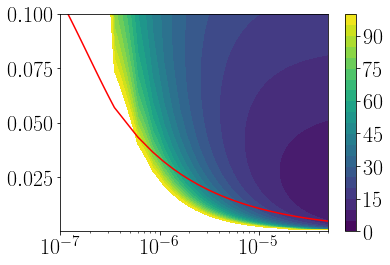

In [72]:
Vi = 0.02
f = 2*np.pi*Vi/1000*np.sqrt(4/5) # find the necessary value of f to keep L = 1 km

N2 = np.linspace(1e-7, 5e-5, 200)
theta = np.linspace(1e-4, 1e-1, 100)

S2 = N2[:,np.newaxis]*theta[np.newaxis,:]**2/f**2

Ha = Vi*f*(1+S2)/(N2[:,np.newaxis]*theta[np.newaxis,:])


plt.contourf(N2, theta, np.transpose(Ha), np.linspace(0, 100, 21))
plt.colorbar()
plt.contour(N2, theta, np.transpose(np.sqrt(S2)), [3e-1], colors='r') 
plt.xscale('log')

So, a possible choice of parameters that is arguably reasonable is given below, along with the associated length scales that would need to be resolved.



In [90]:
Vi = 0.02
f = 1.1e-4
N2 = 1e-5
theta = 0.005

S2 = N2*theta**2/f**2
L = 2*np.pi*Vi/f*np.sqrt((1+1+S2)/(5/2))
Ha = Vi*f*(1+S2)/(N2*theta)
print(f'Horizontal length: {L} m')
print(f'Arrested Ekman height: {Ha} m')
print(f'Slope Burger number: {np.sqrt(S2)}')

Horizontal length: 1027.0555200387341 m
Arrested Ekman height: 44.90909090909091 m
Slope Burger number: 0.14373989364401724


An alternative would be to treat the problem as an initial value problem, starting from a fully stratified interior. We probably will want to do this anyway to study the energetics (as we discussed yesterday), however it might also be useful for fitting into a smaller domain while keeping the interior flow stronger. 

For instance, note that if the boundary layer is not in Ekman arrest, we can scale the velocity for estimating the horizontal length scale of the instability as,
\begin{equation}
V= \frac{H N^2_\infty\theta}{f(1+S^2_\infty)} \approx \frac{H N^2_\infty\theta}{f}.
\end{equation}

Such that,
\begin{equation}
L \approx \frac{2 \pi H N^2_\infty\theta}{f^2}\sqrt{\frac{4}{5}}
\end{equation}
where $H(t)$ will evolve as we discuss in the manuscript. So the expectation would be that the boundary layer starts growing, and becomes unstable to baroclinic modes which are smaller than what we would get starting with the arrested Ekman problem. However, it's a bit hard to anticipate exactly what modes will grow first, as it will be some combination of how quickly the boundary layer deepens, and the resulting growth rates of the baroclinic modes.

This is where doing a ROMS simulation first would likely be helpful. We can see how fast baroclinic modes emerge, and how big they are.

Using $N^2_\infty = 10^{-5}$, $f=10^{-4}$, $\theta = 0.01$ (such that $S = 0.3$), and $V_\infty = 0.1$ m/s I see baroclinic modes emerge after 3 days with $L\approx 1.5$ km, and $H\approx 40$ m (rough visual estimate). This is roughly consistent with the expectation for $L$ using $V \sim \Delta V_g$ across the growing boundary layer.

In [88]:
Vt = 40*1e-5*0.01/(1e-4)
L = 2*np.pi*Vt/1e-4*np.sqrt(4/5)
print(f'Estimate of length scale: {L}m')

Estimate of length scale: 2247.9407139330324m
